In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
def create_blr_problem(dim, seed):
    if dim in [2, 5]:
        signal_std = 1e-3
    else:
        signal_std = 1e-1
    torch.set_default_tensor_type(torch.DoubleTensor)
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=1,
                            signal_std=signal_std,
                            num_targets=100,
                            seed=seed)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [104]:
def compute_preds(d, blr_obj, training_data=False):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [1518]:
def true_preds(blr_obj, training_data=False, seed=1):
    torch.manual_seed(seed)
    samples = blr_obj.weight_posterior.sample((1000,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [1519]:
def var_approx_preds(blr_obj, training_data=False, seed=1):
    torch.manual_seed(seed)
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((1000,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [1520]:
def compute_log_prob_empirical_mog(full_preds, blr):
    normal_dists = dist.normal.Normal(loc=full_preds, scale = signal_std)
    log_probs = normal_dists.log_prob(blr.regression_targets_test)
    sum_of_probs = torch.logsumexp(log_probs, dim=1)
    normalisation_constant = torch.log(torch.tensor(full_preds.shape[1]))
    gmm_log_prob_per_point = sum_of_probs - normalisation_constant
    gmm_log_prob = torch.sum(gmm_log_prob_per_point, dim=1)
    return gmm_log_prob

In [1521]:
def make_gmm(preds, signal_std):
    mix = dist.Categorical(torch.ones((preds.shape[1],)))
    comp = dist.Independent(dist.Normal(loc=preds, scale=signal_std), 1)
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm

In [1522]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

# Ensemble LL

## Test set

In [1523]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 90
beamwidth = 20
emp = []
vari = []
hard = False
for eps in epsilons:
    vari.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [1524]:
blr_seed = 1
b, t = create_blr_problem(dim=dim, seed=blr_seed)

In [1525]:
emp_kl = dist.kl_divergence(t, b.weight_prior)

In [1526]:
var_kl = dist.kl_divergence(compute_variational_posterior(t), b.weight_prior)

In [1527]:
exact_log_probs = make_gmm(true_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [1528]:
exact_var_log_probs = make_gmm(var_approx_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [1529]:
vari_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

In [1530]:
var_gmm = make_gmm(vari_full_preds, signal_std=b.signal_std)
var_log_probs = var_gmm.log_prob(b.regression_targets_test)

In [1531]:
emp_gmm = make_gmm(emp_full_preds, signal_std=b.signal_std)
emp_log_probs = emp_gmm.log_prob(b.regression_targets_test)

In [1532]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=b.signal_std).log_prob(b.regression_targets_test))

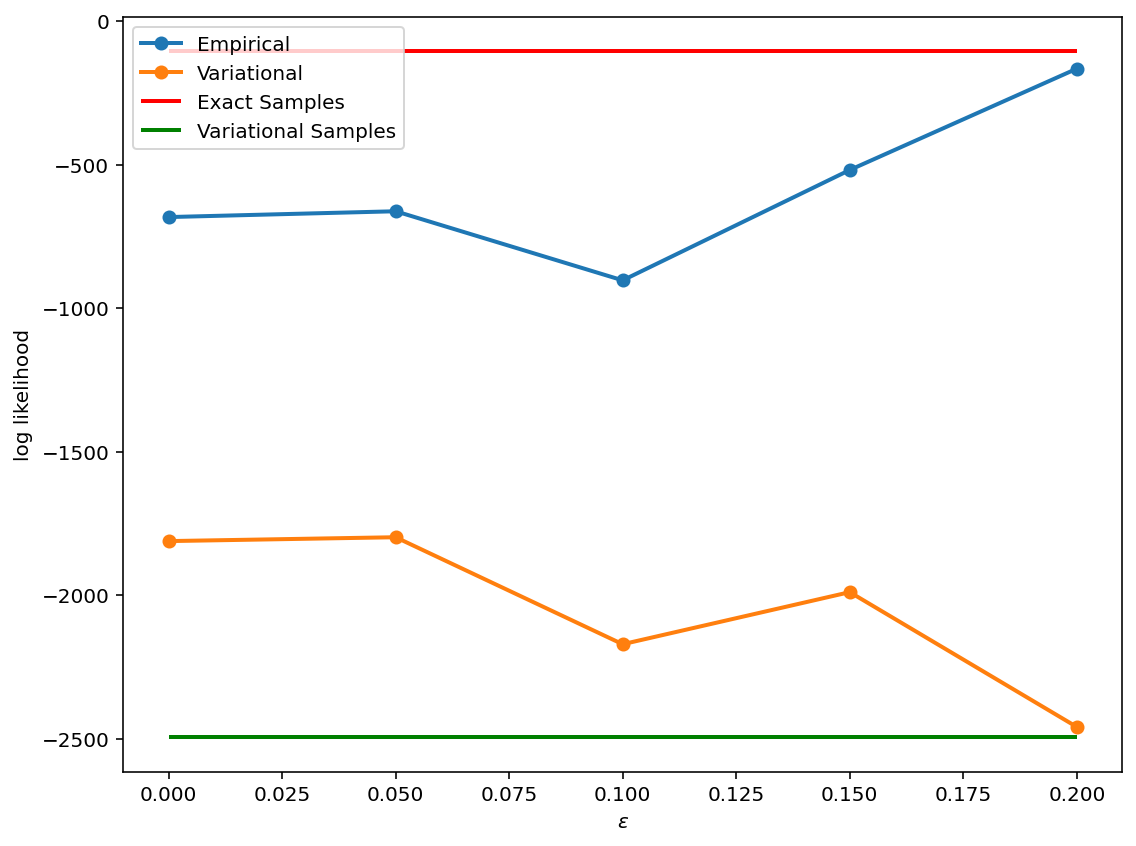

In [1533]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs, '-o', label='Empirical')
ax.plot(epsilons, var_log_probs, '-o', label='Variational')
ax.hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

## Training set

In [1534]:
exact_log_probs_train = make_gmm(true_preds(b, training_data=True)[None], signal_std=b.signal_std).log_prob(b.regression_targets_train)

In [1535]:
exact_var_log_probs_train = make_gmm(var_approx_preds(b, training_data=True)[None], signal_std=b.signal_std).log_prob(b.regression_targets_train)

In [1536]:
vari_full_preds_train = torch.zeros(len(epsilons), 50, len(b.regression_targets_train))
emp_full_preds_train = torch.zeros(len(epsilons), 50, len(b.regression_targets_train))
for i, _ in enumerate(epsilons):
    emp_full_preds_train[i] = compute_preds(emp[i], b, training_data=True)
    vari_full_preds_train[i] = compute_preds(vari[i], b,training_data=True)

In [1537]:
var_gmm = make_gmm(vari_full_preds_train, signal_std=b.signal_std)
var_log_probs_train = var_gmm.log_prob(b.regression_targets_train)

In [1538]:
emp_gmm = make_gmm(emp_full_preds_train, signal_std=b.signal_std)
emp_log_probs_train = emp_gmm.log_prob(b.regression_targets_train)

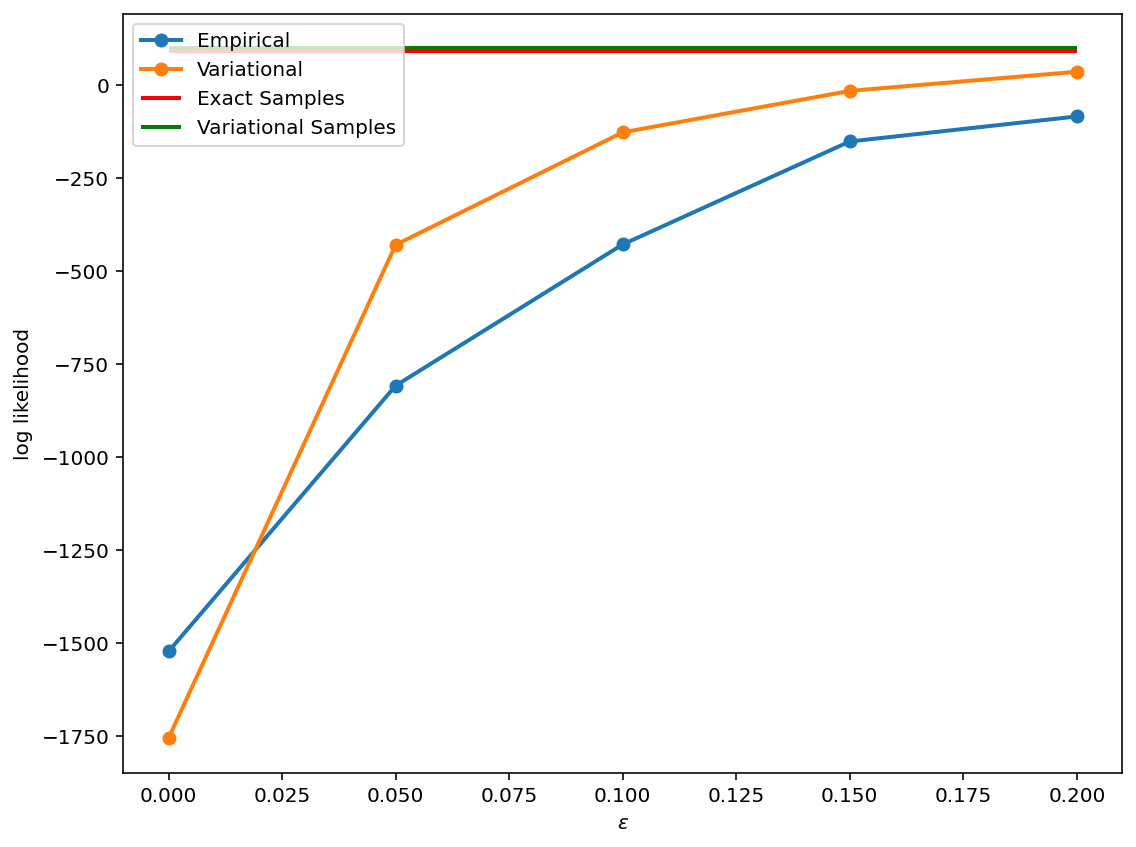

In [1539]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs_train, '-o', label='Empirical')
ax.plot(epsilons, var_log_probs_train, '-o', label='Variational')
ax.hlines(exact_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

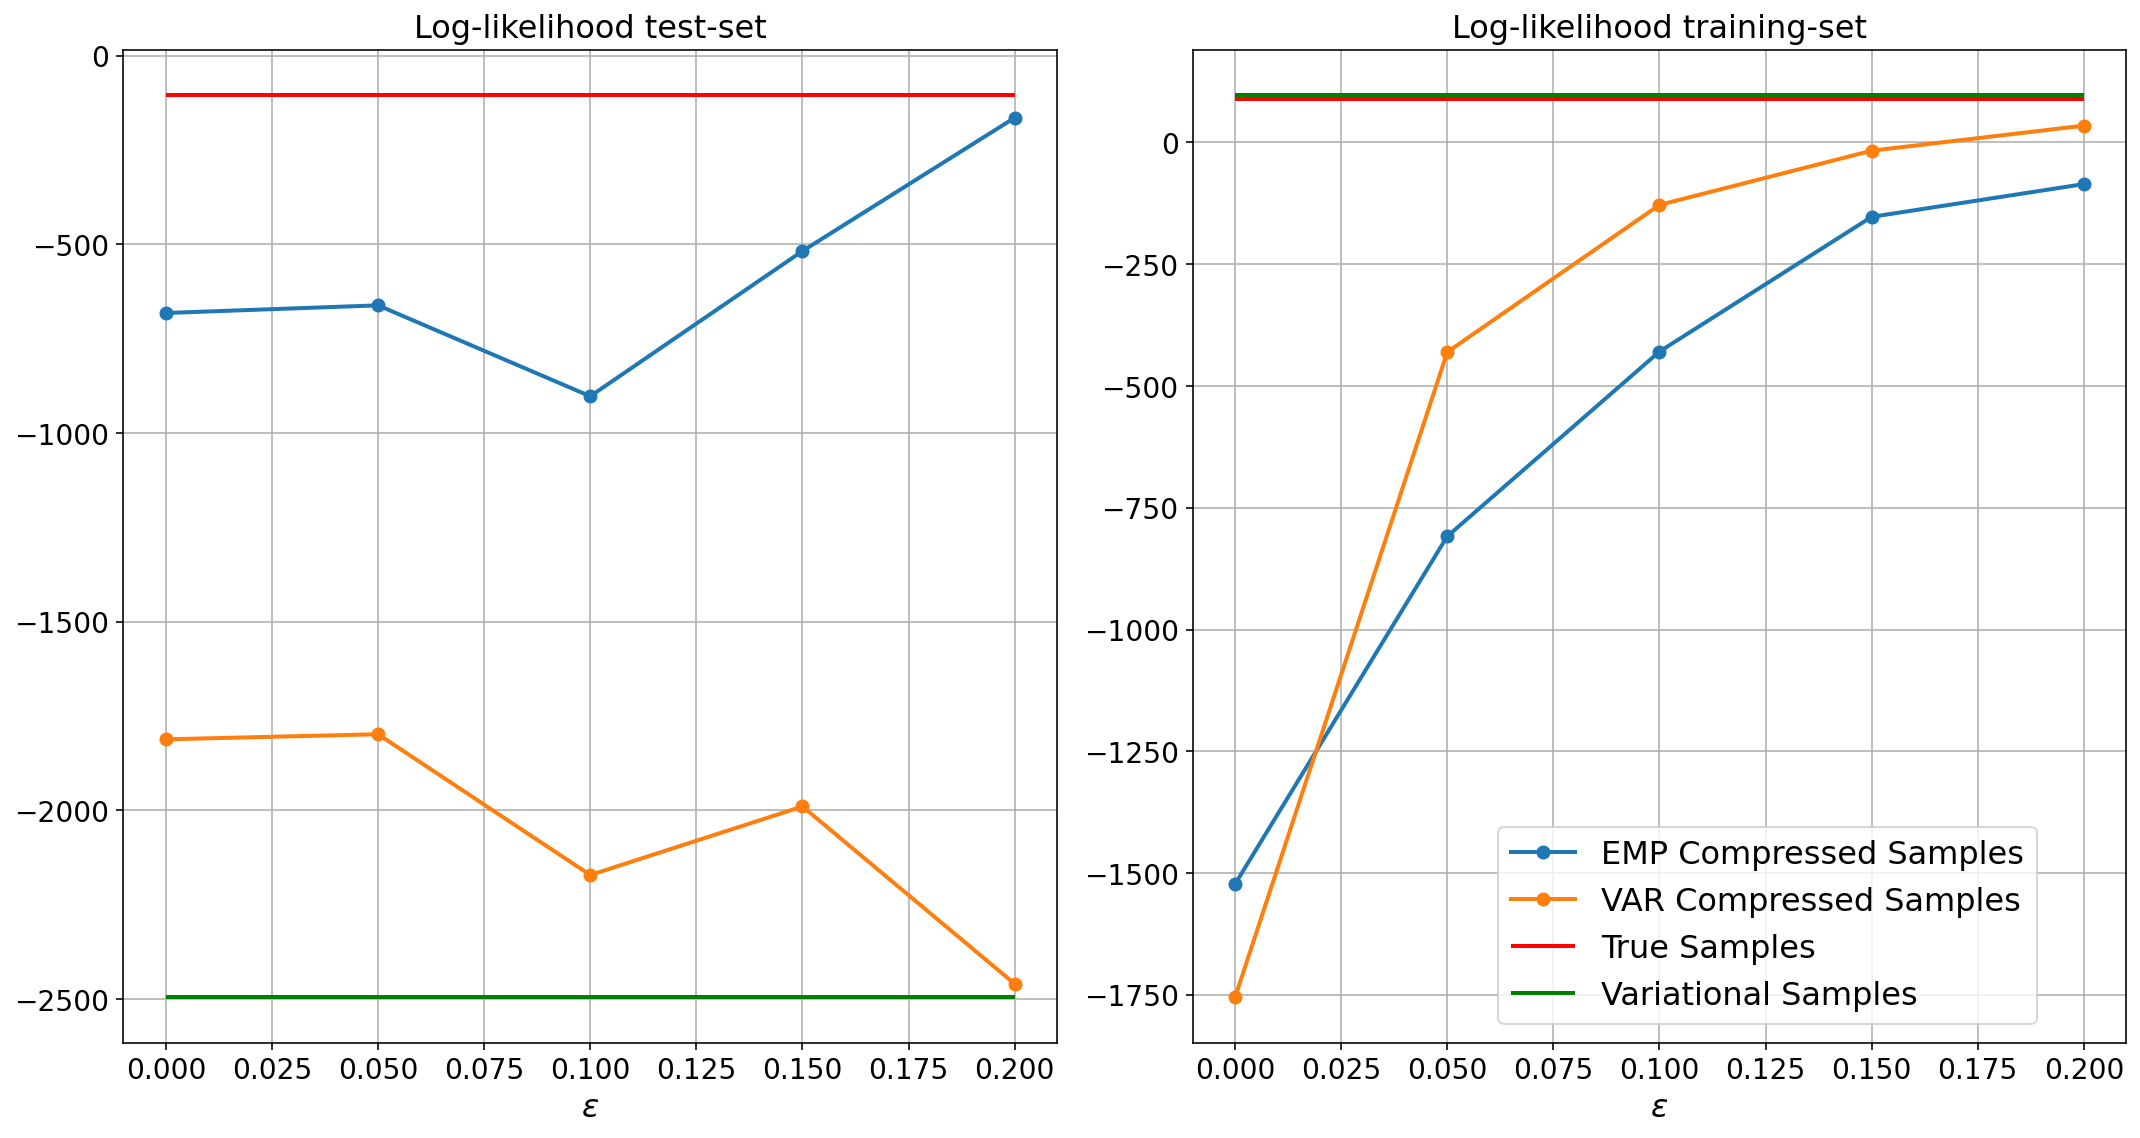

In [1540]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(epsilons, emp_log_probs, '-o', label='Empirical')
ax[0].plot(epsilons, var_log_probs, '-o', label='Variational')
ax[0].hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax[0].hlines(exact_var_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='green')
ax[0].grid()
ax[0].set_xlabel(r'$\epsilon$', fontsize=16)
ax[1].grid()
ax[1].set_xlabel(r'$\epsilon$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[1].plot(epsilons, emp_log_probs_train, '-o', label='Empirical')
ax[1].plot(epsilons, var_log_probs_train, '-o', label='Variational')
ax[1].hlines(exact_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax[1].hlines(exact_var_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='green')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP Compressed Samples', 'VAR Compressed Samples', 'True Samples', 'Variational Samples'], loc = (0.7, 0.1), ncol=1, fontsize=16)
f.tight_layout()

# MSE

## Test

In [1461]:
exact_preds = true_preds(b)
var_preds = var_approx_preds(b)

In [1462]:
exact_rmse = torch.sqrt(((exact_preds.mean(0) - b.regression_targets_test) ** 2 / exact_preds.var(0)).mean())

In [1463]:
var_rmse = torch.sqrt(((var_preds.mean(0) - b.regression_targets_test) ** 2 / var_preds.var(0)).mean())

In [1464]:
emp_rmse = torch.sqrt(((emp_full_preds.mean(1) - b.regression_targets_test) ** 2 / emp_full_preds.var(1)).mean(1))

In [1465]:
vari_rmse=torch.sqrt(((vari_full_preds.mean(1) - b.regression_targets_test) ** 2 / vari_full_preds.var(1)).mean(1))

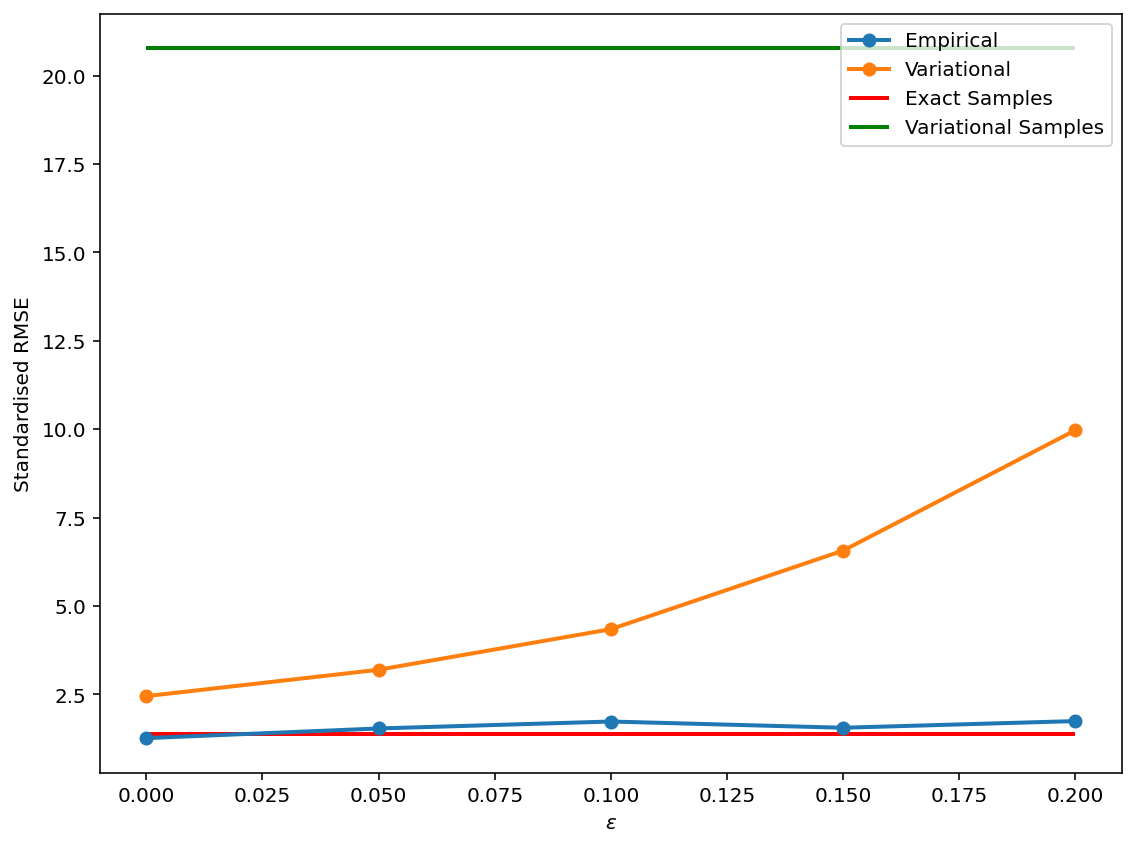

In [1466]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_rmse, '-o', label='Empirical')
ax.plot(epsilons, vari_rmse, '-o', label='Variational')
ax.hlines(exact_rmse, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_rmse, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised RMSE')
ax.legend()
fig.tight_layout()

## train

In [1467]:
exact_preds_train = true_preds(b, training_data=True)
var_preds_train = var_approx_preds(b, training_data=True)

In [1468]:
exact_rmse_train = torch.sqrt(((exact_preds_train.mean(0) - b.regression_targets_train) ** 2 / exact_preds_train.var(0)).mean())

In [1469]:
var_rmse_train = torch.sqrt(((var_preds_train.mean(0) - b.regression_targets_train) ** 2 / var_preds_train.var(0)).mean())

In [1470]:
emp_rmse_train = torch.sqrt(((emp_full_preds_train.mean(1) - b.regression_targets_train) ** 2 / emp_full_preds_train.var(1)).mean(1))

In [1471]:
vari_rmse_train =torch.sqrt(((vari_full_preds_train.mean(1) - b.regression_targets_train) ** 2 / vari_full_preds_train.var(1)).mean(1))

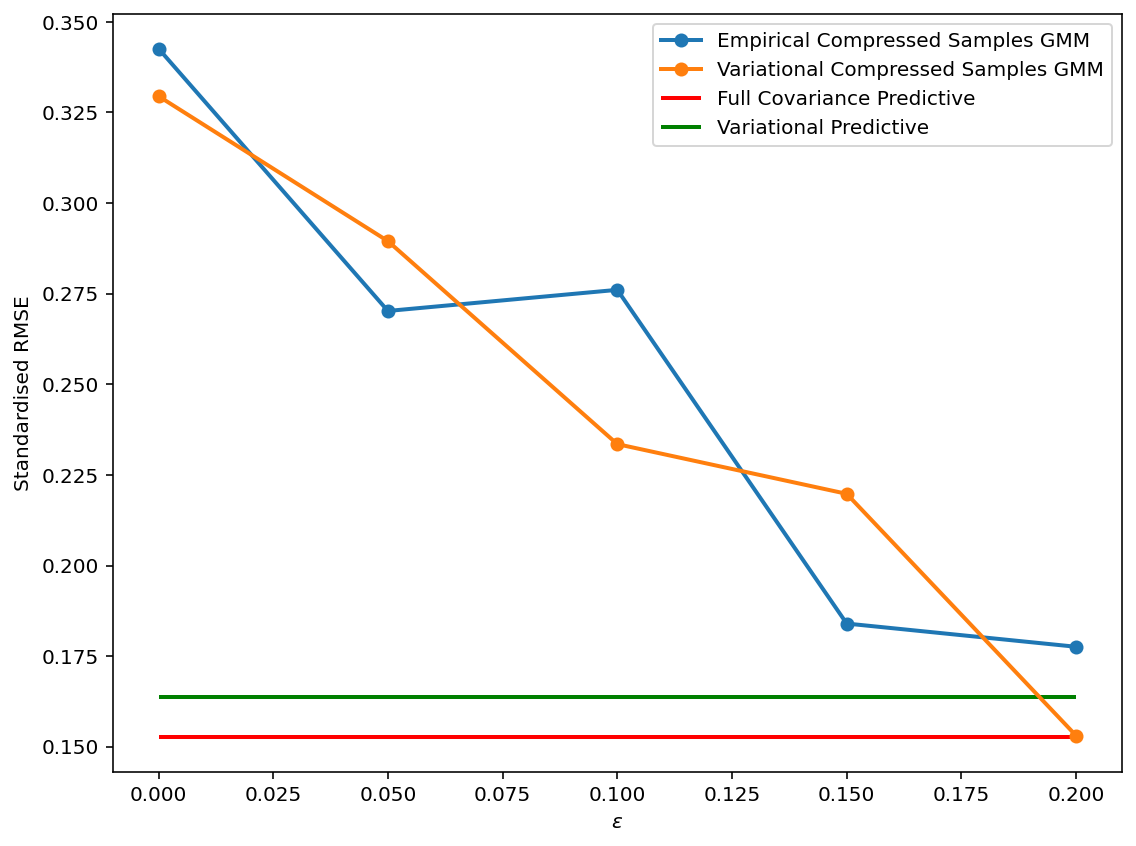

In [1472]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_rmse_train, '-o', label='Empirical Compressed Samples GMM')
ax.plot(epsilons, vari_rmse_train, '-o', label='Variational Compressed Samples GMM')
ax.hlines(exact_rmse_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Full Covariance Predictive')
ax.hlines(var_rmse_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Predictive')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised RMSE')
ax.legend()
fig.tight_layout()

# MAE

## Test

In [1473]:
exact_preds = true_preds(b)
var_preds = var_approx_preds(b)

In [1474]:
exact_mae = (torch.abs(exact_preds.mean(0) - b.regression_targets_test) / exact_preds.std(0)).mean()

In [1475]:
var_mae = (torch.abs(var_preds.mean(0) - b.regression_targets_test) / var_preds.std(0)).mean()

In [1476]:
emp_mae = (torch.abs(emp_full_preds.mean(1) - b.regression_targets_test) / emp_full_preds.std(1)).mean(1)

In [1477]:
vari_mae = (torch.abs(vari_full_preds.mean(1) - b.regression_targets_test) / vari_full_preds.std(1)).mean(1)

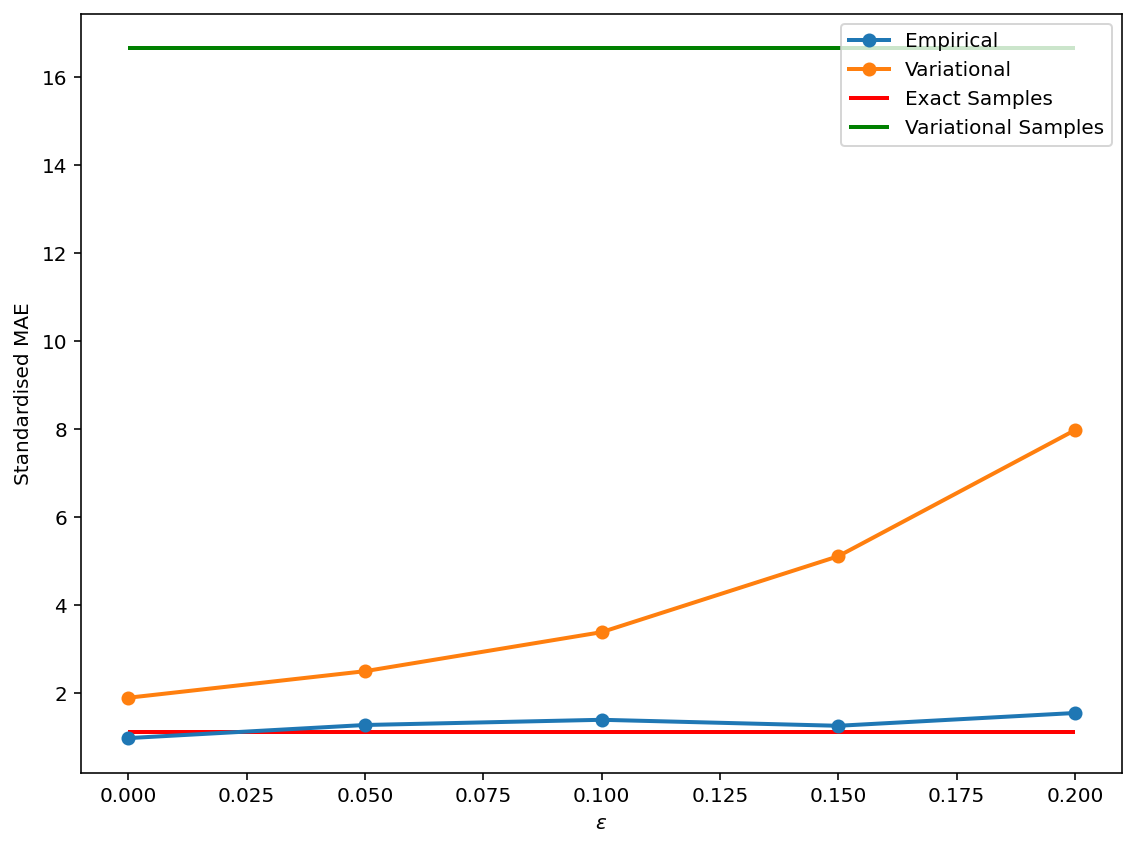

In [1478]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_mae, '-o', label='Empirical')
ax.plot(epsilons, vari_mae, '-o', label='Variational')
ax.hlines(exact_mae, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_mae, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised MAE')
ax.legend()
fig.tight_layout()

## train

In [1479]:
exact_mae_train = (torch.abs(exact_preds_train.mean(0) - b.regression_targets_train) / exact_preds_train.std(0)).mean()

In [1480]:
var_mae_train = (torch.abs(var_preds_train.mean(0) - b.regression_targets_train) / var_preds_train.std(0)).mean()

In [1481]:
emp_mae_train = (torch.abs(emp_full_preds_train.mean(1) - b.regression_targets_train) / emp_full_preds_train.std(1)).mean(1)

In [1482]:
vari_mae_train = (torch.abs(vari_full_preds_train.mean(1) - b.regression_targets_train) / vari_full_preds_train.std(1)).mean(1)

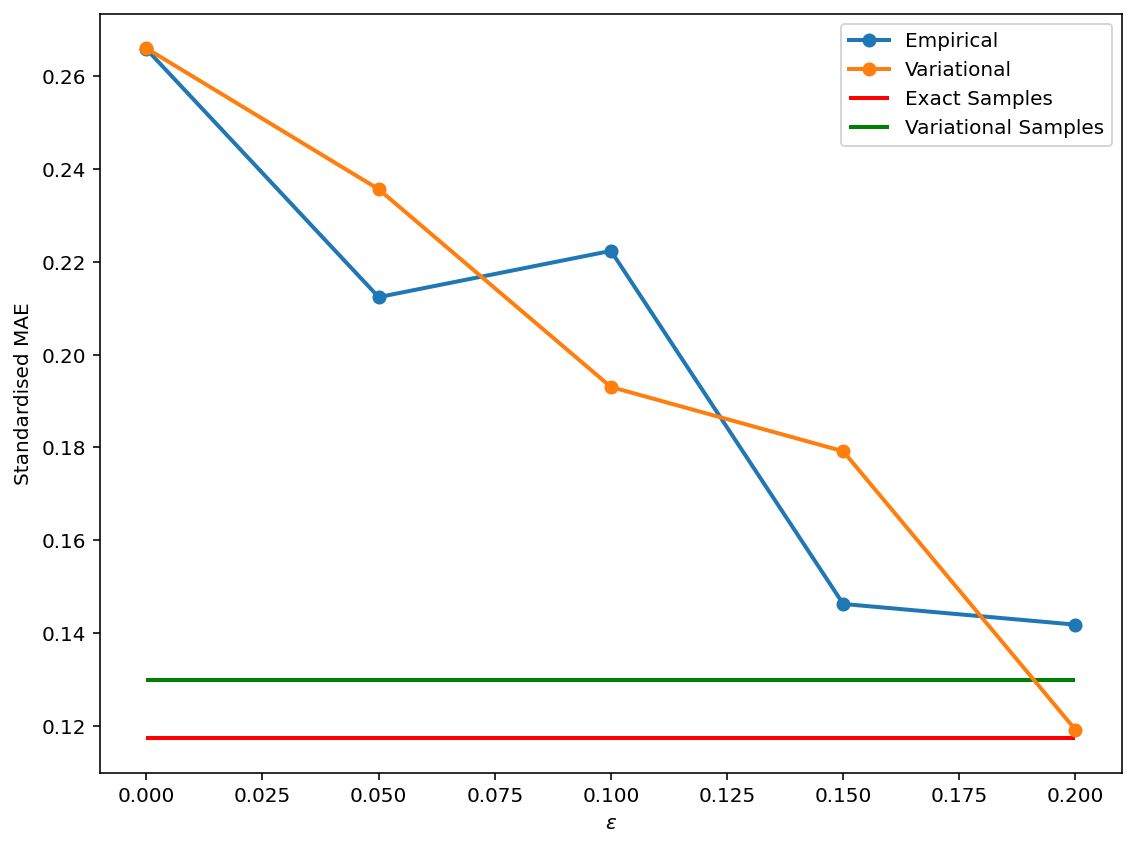

In [1483]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_mae_train, '-o', label='Empirical')
ax.plot(epsilons, vari_mae_train, '-o', label='Variational')
ax.hlines(exact_mae_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_mae_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised MAE')
ax.legend()
fig.tight_layout()

# Summary Table

## Test Set

In [1484]:
emp_coding_efficiency = [compute_expected_coding_efficiency(emp_kl, epsilon=e).numpy() for e in epsilons]

In [1485]:
var_coding_efficiency = [compute_expected_coding_efficiency(var_kl, epsilon=e).numpy() for e in epsilons]

In [1486]:
import pandas as pd

In [1487]:
summary_test = pd.DataFrame(index=['True Posterior', 'Compressed EMP', 'Variational Posterior', 'Compressed VAR'],
                            columns=['Log-likelihood', 'SRMSE', 'SMAE', 'Expected Coding Efficiency (Nats)'])

In [1488]:
summary_test.loc['True Posterior'] = [float(exact_log_probs.numpy()), float(exact_rmse.numpy()), float(exact_mae.numpy()), float('nan')]

summary_test.loc['Variational Posterior'] = [float(exact_var_log_probs.numpy()), float(var_rmse.numpy()), float(var_mae.numpy()), float('nan')]

In [1489]:
summary_test.loc['Compressed EMP'] = [float(emp_log_probs.numpy()[-1]), float(emp_rmse.numpy()[-1]), float(emp_mae.numpy()[-1]), emp_coding_efficiency[-1]]
summary_test.loc['Compressed VAR'] = [float(var_log_probs.numpy()[-1]), float(vari_rmse.numpy()[-1]), float(vari_mae.numpy()[-1]), var_coding_efficiency[-1]]

In [1490]:
summary_test.astype(float).round(2).mask(summary_test.isna(), 'N/A')

,Log-likelihood,SRMSE,SMAE,Expected Coding Efficiency (Nats)
True Posterior,-175.2,1.37,1.12,N/A
Compressed EMP,-164.88,1.75,1.55,443.45
Variational Posterior,-2643.39,20.77,16.64,N/A
Compressed VAR,-2459.28,9.97,7.97,498.99


## Train Set

In [1491]:
emp_coding_efficiency = torch.tensor([compute_expected_coding_efficiency(emp_kl, epsilon=e) for e in epsilons])

In [1492]:
var_coding_efficiency = torch.tensor([compute_expected_coding_efficiency(var_kl, epsilon=e) for e in epsilons])

In [1493]:
import pandas as pd

In [1494]:
summary_train = pd.DataFrame(index=['True Posterior', 'Compressed EMP', 'Variational Posterior', 'Compressed VAR'],
                            columns=['Log-likelihood', 'SRMSE', 'SMAE', 'Expected Coding Efficiency (Nats)'])

In [1495]:
summary_train.loc['True Posterior'] = [float(exact_log_probs_train.numpy()), float(exact_rmse_train.numpy()), float(exact_mae_train.numpy()), float('nan')]

summary_train.loc['Variational Posterior'] = [float(exact_var_log_probs_train.numpy()), float(var_rmse_train.numpy()), float(var_mae_train.numpy()), float('nan')]

In [1496]:
summary_train.loc['Compressed EMP'] = [float(emp_log_probs_train.numpy()[-1]), float(emp_rmse_train.numpy()[-1]), float(emp_mae_train.numpy()[-1]), emp_coding_efficiency[-1]]
summary_train.loc['Compressed VAR'] = [float(var_log_probs_train.numpy()[-1]), float(vari_rmse_train.numpy()[-1]), float(vari_mae_train.numpy()[-1]), var_coding_efficiency[-1]]

In [1497]:
summary_train.astype(float).round(2).mask(summary_train.isna(), 'N/A')

,Log-likelihood,SRMSE,SMAE,Expected Coding Efficiency (Nats)
True Posterior,87.93,0.15,0.12,N/A
Compressed EMP,-85.6,0.18,0.14,443.45
Variational Posterior,90.03,0.16,0.13,N/A
Compressed VAR,34.39,0.15,0.12,498.99
